In [1]:
import pandas as pd
import konlpy
from konlpy.tag import Komoran
from pprint import pprint
from collections import defaultdict
from collections import Counter
import warnings # 경고 알림 제거
print(konlpy.__version__)
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook # progress bar
#from konlpy.tag import Mecab #Mecab, Okt 등 형태소 분석기 불러오기,앞에서 코모란불러옴 
import numpy as np
import string # 특수문자
from gensim import corpora
from gensim import models
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) # 경고 알림이 뜨면 모두 무시


0.5.2


In [2]:
komoran=Komoran()

In [3]:
data = pd.read_excel('speech.xlsx', engine='openpyxl')

In [4]:
data = data.iloc[:,:6]
data.head(10)

,산업군,기업명,연도,발표자,전문,출처
0,전자,삼성전자,2021,김기남,"김기남 삼성전자 부회장은 ""변화 물결 속에서 한 단계 더 도약하기 위해 2021년은...",출처 : https://biz.chosun.com/site/data/html_dir...
1,전자,삼성전자,2020,김기남,"김기남 삼성전자 부회장은 2일 ""경기변화에 강건한 사업 체질을 만들자""고 강조했다....",출처 : https://biz.chosun.com/site/data/html_dir...
2,전자,삼성전자,2019,김기남,"삼성전자는 2일 수원 삼성 디지털시티에서 김기남 부회장, 김현석 사장, 고동진 사장...",출처 : http://it.chosun.com/site/data/html_dir/2...
3,전자,삼성전자,2018,김기남,김기남 삼성전자디바이스솔루션(DS) 부문장(사장⋅사진)은 2일 삼성전자 시무식에서 ...,출처 : https://biz.chosun.com/site/data/html_dir...
4,전자,삼성전자,2017,권오현,권오현 삼성전자 부회장은 새해를 맞아 임직원들에게 '새로운 시작'과 '완벽한 쇄신'...,출처 : http://it.chosun.com/site/data/html_dir/2...
5,전자,삼성SDI,2021,전영현,전영현 삼성SDI 사장은 신년을 맞아 “최고 품질 확보와 안전 문제 제로를 달성해 ...,출처 : https://www.ajunews.com/view/202101040848...
6,전자,삼성SDI,2020,전영현,"삼성SDI 전영현(사진) 사장은 2020년 신년사를 통해 ""창립 50주년을 맞은 올...",출처 : https://biz.chosun.com/site/data/html_dir...
7,전자,삼성SDI,2019,전영현,"전영현 삼성SDI 사장이 2일 신년사를 통해 임직원들에게 ""혁신 마인드와 강한 실행...",출처 : http://it.chosun.com/site/data/html_dir/2...
8,전자,삼성SDI,2018,전영현,전영현 삼성SDI사장(사진)은 “시장을 선점하기 위해서는 무엇보다 중요한 것이 차별...,출처 : https://biz.chosun.com/site/data/html_dir...
9,전자,삼성SDI,2017,조남성,조남성 삼성SDI 사장은 2017년 새해에는 “본질적 경쟁력을 확보해 어려운 경영환...,출처 : https://www.ajunews.com/view/201701021034...


In [5]:
# 결측치 확인
data.isnull().sum()

산업군     0
기업명     0
연도      0
발표자     0
전문      0
출처     32
dtype: int64

한국어 형태소분석기는 영어 단어를 인식하지 못하므로, 영어단어를 임의로 한글로 바꿈

In [6]:
# 전처리 함수
import re 

def clean_text(text):    
    
    pattern='(\[a-zA-Z0-9\_.+-\]+@\[a-zA-Z0-9]+.\[a-zA-Z0-9-.\]+)' # email제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    text = text.upper()
    
    pattern = '([ㄱ-ㅎㅏ-ㅣ])+' # 한글 자음, 모음 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'([^\w]?\d+\.?\,?\)?\d*)+') # 숫자 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='<[^>]*>' # html 태그 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='[\r|\n]' # \r,\n 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern= '[^\w\s]' # 특수기호 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'\s+')  #  이중 space 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)

#     hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자
#     text=re.sub(pattern=hangul,repl=' ',string=text) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
    
    text=text.strip()
    return text

In [7]:
data['전문1'] = data['전문'].apply(clean_text)

In [8]:
##사용자 사전 추가하기
komoran_userdic=Komoran(userdic='./userdic_speech.txt')

In [9]:
#불용어에 발표자,기업이름도 넣음
SW = ['사장님','사장','임직원','사진','그럼에도 불구하고','정유', '이날', '시무식', '대표', '이사','부회장',
      '김현석','고동진', '온라인','해로', '지난해', '올해', '사자성', '당부','오전','경기', '수원', '삼성', '포스트',
      '전영', '신년', '신년사', '창립', '주년', '경기도', '엠블럼','가지', '회장', '더 가까이', '여러분', '안녕하십니까',
      '새해', '발표', '포로', '정호', '구성원', '현대자동차그룹','해주시', '앞으로', '그룹', '나가야', '경자', '니다',
      '오늘','내일', '현대백화점그룹', 'SK텔레콤', 'SK브로드밴드', 'LG CNS', '대로', '모두', '감사', '가족', '친애',
      '흰 소', '신축년', '사랑', '기해','돼지', '힘찬','만큼', '선도해', '주시', '은행장', '출처', '신아일보', '신한',
      '너머','고맙습니다', '행복', '약속', '모아', 'ON', '하나금융그룹', '마리', '직원', '한마음', '다운', '뉴스',
      '다보스', '농협', 'NH농협은행','가지', '가슴', '호시','여럿','폴리스','기적을','때문','가와', '장이','자리',
      '이병', '사와', '시상', '하나로', '발짝', '여명', '투데이', '신문',' 작성', '기사', '종수','열자', '승호', '우선시',
      '국민','장한', '보령', '제약','SK이노베이션','무술','허진','GS칼텍스','한해','예년','라고','한진그룹','현대중공업그룹',
      '반갑습니다', '동안','별도','근간','메시지','마무리','대림','곳곳','가교','스키','팍스','아무것','금년','강조',
      '기원','노고','가정','건강','작년','마지막','전문','한편','마음','가운데','최근','정도','향후','자랑','그동안',
      '다짐','아침','목소리','중앙은행','행위','기쁨','명심'
     ]  + \
    list(set(data['발표자'])) +  list(set(data['기업명']))

In [10]:
# 해당 단어가 전문에 있는지 확인
[x for x in data['전문1'] if '수주' in x]

['김영섭 LG CNS 사장이 일 LG CNS 임직원을 대상으로 비대면 신년 메시지를 전달했다 김영섭 사장은 코로나 확산으로 일상이 멈추고 생산과 소비가 동시 위축하는 현상을 경험하는 상황에서 LG CNS는 원격 비대면으로 일하는 방식을 빠르게 전환하는 데 성공했다 며 작금의 위기가 디지털 전환 준비가 철저했던 기업에게는 기회 라고 평가했다 김 사장은 디지털 전환 추진에 명쾌한 해법을 찾지 못하는 기업 고객의 페인 포인트 PAIN POINT 취약점 를 해결하는 LG CNS의 디지털 혁신 선도자 DIGITAL INNOVATION ENABLER 로서의 역할을 강조했다 올해 기업 고객의 디지털 전환 수요가 커질 것이며 이를 위해 LG CNS가 선제적이고 철저하며 민첩한 준비를 해야 한다는 설명이다 김 사장은 올해 경영 방침으로 전문 역량의 혁신 지속 과 사업모델의 본격적 혁신 을 당부했다 그는 기술 발전속도를 따라잡기 위해 전문기업이나 기술기업과의 협업이 필수이며 실질적이고 유의미한 협업을 이끌어내는 것 역시 LG CNS가 갖춰야 할 역량이자 경쟁력이다 구성원들도 전문 역량 혁신을 지속해 협업 전문가로 성장해야 한다 고 강조했다 이어 LG CNS는 다양한 기술을 접목해 새로운 서비스를 만드는 데 강점을 갖고 있다 사업 모델을 혁신해 수주형 사업을 넘어 다양한 서비스형 사업을 만들고 스스로 시장을 창출해야 한다 며 LG CNS 구성원들이 가격보다 가치 중심으로 일함으로써 전문 역량에 걸맞은 대우를 받고 IT 서비스의 격을 높이는 데 만전을 기해주길 바란다 고 덧붙였다',
 'SK이노베이션 계열 구성원 여러분 새로운 성장을 위해 힘찬 발걸음을 내디뎠던 년을 뒤로 하고 희망찬 년 새해를 맞이하였습니다 황금돼지의 복된 기운을 받아 구성원 여러분과 가족 모두 행복하고 풍요로운 한 해가 되시기를 기원합니다 지난 한 해 SK이노베이션 계열은 구성원 여러분이 DEEP CHANGE 실행을 위해 보여 준 열정과 패기 덕분에 다양한 영역에서 가시적인 성과를 거둘 수 있었습니다 SK에너

In [11]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    corpus = []
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
    for page in temp_corpus:
        corpus += page
    return corpus

def text_tokenizing(corpus, tokenizer):
    token_corpus = []

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = komoran_userdic.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenized == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = komoran_userdic.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

        
    return token_corpus

In [12]:
data['전문2'] = text_tokenizing(data['전문1'], tokenizer="noun")

Preprocessing:   0%|          | 0/215 [00:00<?, ?it/s]

In [13]:
# 명사 추출 후 해당 단어가 있는지 확인
[x for x in data['전문2'] if '삼성전자' in x]

[]

In [14]:
data.to_excel('preprocessing.xlsx', index=None, encoding='utf-8')

In [15]:
data.to_csv('preprocessing.csv', index=None, encoding='utf-8')

---
* 빈도수 확인

In [16]:
def flatten(l):
    flatList=[]
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList

In [17]:
cleaned_nouns = flatten(data['전문2'])

In [28]:
pd.Series(cleaned_nouns).value_counts().head(50)#상위50개 보여주기 

금융     684
고객     640
성장     587
사업     579
혁신     481
변화     470
시장     467
경영     442
회사     435
기업     406
미래     349
강화     340
글로벌    330
노력     313
환경     311
지속     290
경쟁력    283
기술     267
가치     262
역량     254
경제     251
조직     240
추진     231
디지털    228
확보     222
기반     221
확대     220
문화     219
중심     207
성과     196
목표     194
은행     192
상황     184
산업     181
필요     174
도전     171
수익     168
안전     167
관리     165
업무     164
사회     161
개선     160
위기     157
서비스    157
구축     156
적극     156
개발     155
창출     149
생각     146
신뢰     143
dtype: int64

#### 특정 산업군 상위 단어빈도수 확인  
ex) 전자

In [19]:
elec = flatten(data['전문2'][data['산업군'] == '전자'])

In [20]:
pd.Series(elec).value_counts().head(30) 

사업      66
고객      55
성장      53
기술      48
문화      43
시장      41
혁신      39
변화      39
경영      39
경쟁력     36
기반      35
제품      30
미래      30
확보      30
가치      29
기업      27
조직      26
회사      25
품질      23
도전      20
강화      19
준비      19
추진      19
창출      19
사회      19
OLED    19
수익      18
역량      17
환경      16
성과      16
dtype: int64

#### 특정 연도 상위 단어빈도수 확인  
ex) 전자

In [21]:
y_21 = flatten(data['전문2'][data['연도'] == 2021])

In [22]:
pd.Series(y_21).value_counts().head(30) 

고객     164
금융     159
사업     141
성장     123
변화     116
기업     108
코로나    102
혁신      93
시장      90
경영      87
강화      87
회사      83
환경      77
디지털     73
지속      72
가치      72
미래      71
글로벌     65
위기      63
기반      63
역량      62
확대      61
기술      59
경쟁력     57
조직      56
추진      55
노력      54
경제      53
사회      53
중심      51
dtype: int64

---
* WordCloud 예시

In [23]:
def __array__(self):
    """Convert to numpy array.
    Returns 
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()
def to_array(self):
    return np.array(self.to_image())


In [24]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
#윈도우용 font_path = 'C:/Windows/Fonts/malgun.ttf'
font_path='C:/Windows/Fonts/malgun.ttf'
wordcloud=WordCloud(font_path=font_path, width=800, height=800, 
                    background_color="white", colormap="Set2")

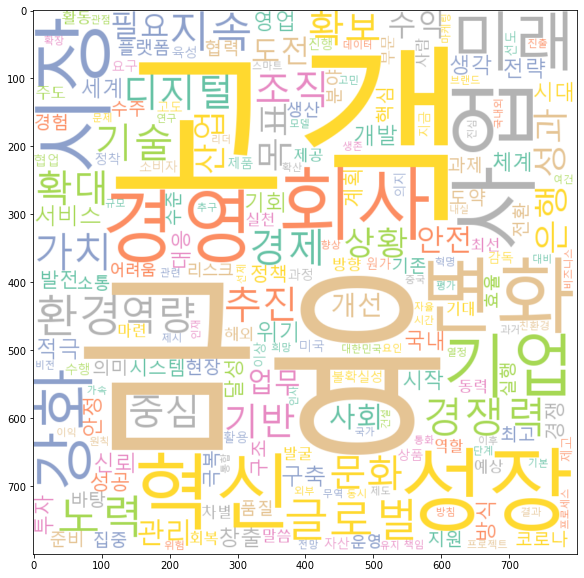

In [26]:
wordcloud=wordcloud.generate_from_frequencies(Counter(cleaned_nouns))
array=wordcloud.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

---
preprocessing.csv 부를때, 리스트인 대괄호를 문자로 인식함. 이를 해결하기 위한 코드
``` c
from ast import literal_eval
data=pd.read_csv('preprocessing.csv', converters={'전문2': literal_eval})
```